# Pretrain the GPT2 model

This notebook seeks to replicate Andrey Karpathy's highly popular [nanoGPT](https://github.com/karpathy/nanoGPT/tree/master) project and trains a GPT2 model from scratch using JAX+TPU and the [OpenWebText dataset](https://huggingface.co/datasets/Skylion007/openwebtext).

You can run this on Colab, Kaggle or GCP TPUs, although Colab TPU v2 can only run the smallest 124M GPT model.


## Determine platform

In [ ]:
import os
if os.path.exists('/content/'):
  platform = "Colab"
elif os.path.exists('/kaggle/'):
  platform = "Kaggle"
else:
  # Assume using Cloud TPU otherwise
  platform = "GCP"

## Setup

Install JAX and Flax first.

In [ ]:
!pip install -q jax-ai-stack
!pip install -Uq "jax[tpu]" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
!pip install -Uq tiktoken matplotlib kaggle wandb tpu-info orbax-checkpoint

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-tpu 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Confirm we have TPUs set up.

In [ ]:
import jax
jax.devices()

E0000 00:00:1751448316.974959      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

Take care of the imports.

In [ ]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx
import optax, orbax
from collections import Counter
from dataclasses import dataclass
from jax.experimental import mesh_utils
from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
import numpy as np
import tiktoken, time, wandb

## Build the model

Define the device mesh.


In [ ]:
### Alternative data and model parallel
#mesh = jax.make_mesh((4, 2), ('batch', 'model'))

mesh = jax.make_mesh((8, 1), ('batch', 'model'))

We are going to use the GPT-2 tokenizer via OpenAI's [Tiktoken](https://github.com/openai/tiktoken) library.

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

Set some hyperparameters.

In [ ]:
vocab_size = tokenizer.n_vocab
GPT2_variant = "GPT2" # "GPT2-medium"
if GPT2_variant == "GPT2-medium":
  num_transformer_blocks = 24
  seqlen = 1024
  embed_dim = 1024
  num_heads = 16
  feed_forward_dim = 4 * embed_dim
  batch_size = 32  # Can only run on TPU v3+
else: ## Assume GPT2 otherwise
  num_transformer_blocks = 12
  seqlen = 1024
  embed_dim = 768
  num_heads = 12
  feed_forward_dim = 4 * embed_dim
  if platform == "Colab":
      batch_size = 24 # TPU v2
  else:
      batch_size = 72 # TPU v3

dropout_rate = 0.1

max_steps = 600000*12//batch_size
# Kaggle TPU limit per session is 9 hours, which is ~95K steps for GPT2
if platform == "Kaggle":
  max_steps = 90000
init_learning_rate = 5e-4
weight_decay = 1e-1
top_k = 10
dtype = jnp.bfloat16
param_dtype = jnp.float32

Now define the model architecture. You can refer to [OpenAI's official implementation](https://github.com/openai/gpt-2) or [nanoGPT](https://github.com/karpathy/nanoGPT) for comparison. Main difference is with the sharding scheme.

In [ ]:
def causal_attention_mask(seq_len):
    return jnp.tril(jnp.ones((seq_len, seq_len)))

class TransformerBlock(nnx.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout_rate: float, rngs: nnx.Rngs):
        self.layer_norm1 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), ('model',)),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), ('model',)),
                                         dtype=dtype,
                                         param_dtype=param_dtype,
                                         rngs=rngs)
        self.mha = nnx.MultiHeadAttention(num_heads=num_heads,
                                          in_features=embed_dim,
                                          kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), (None, 'model')),
                                          bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), ('model',)),
                                          dtype=dtype,
                                          param_dtype=param_dtype,
                                          rngs=rngs)
        self.dropout1 = nnx.Dropout(rate=dropout_rate)  # Added dropout layer after MHA
        self.layer_norm2 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), ('model',)),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), ('model',)),
                                         dtype=dtype,
                                         param_dtype=param_dtype,
                                         rngs=rngs)
        self.linear1 = nnx.Linear(in_features=embed_dim,
                                  out_features=ff_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), (None, 'model')),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), ('model',)),
                                  dtype=dtype,
                                  param_dtype=param_dtype,
                                  rngs=rngs)
        self.linear2 = nnx.Linear(in_features=ff_dim,
                                  out_features=embed_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), (None, 'model')),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), ('model',)),
                                  dtype=dtype,
                                  param_dtype=param_dtype,
                                  rngs=rngs)
        self.dropout2 = nnx.Dropout(rate=dropout_rate)

    def __call__(self, inputs, training: bool = False):
        input_shape = inputs.shape
        bs, seq_len, emb_sz = input_shape

        attention_output = self.mha(
            inputs_q=self.layer_norm1(inputs),
            mask=causal_attention_mask(seq_len),
            decode=False,
        )
        x = inputs + self.dropout1(attention_output, deterministic=not training)

        # MLP
        mlp_output = self.linear1(self.layer_norm2(x))
        mlp_output = nnx.gelu(mlp_output)
        mlp_output = self.linear2(mlp_output)
        mlp_output = self.dropout2(mlp_output, deterministic=not training)

        return x + mlp_output


class TokenAndPositionEmbedding(nnx.Module):

    def __init__(self, seqlen: int, vocab_size: int, embed_dim: int, rngs: nnx.Rngs):
        self.token_emb = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, dtype=dtype, param_dtype=param_dtype, rngs=rngs)
        self.pos_emb = nnx.Embed(num_embeddings=seqlen, features=embed_dim, dtype=dtype, param_dtype=param_dtype, rngs=rngs)

    def __call__(self, x):
        positions = jnp.arange(0, x.shape[1])[None, :]
        position_embedding = self.pos_emb(positions)
        token_embedding = self.token_emb(x)
        return self.token_emb, token_embedding+position_embedding


class GPT2(nnx.Module):
    def __init__(self, seqlen: int, vocab_size: int, embed_dim: int, num_heads: int, rate: float, feed_forward_dim: int, num_transformer_blocks: int, rngs: nnx.Rngs):
        self.embedding_layer = TokenAndPositionEmbedding(
                    seqlen, vocab_size, embed_dim, rngs=rngs
                )
        self.dropout = nnx.Dropout(rate=rate)

        self.transformer_blocks = [TransformerBlock(
            embed_dim, num_heads, feed_forward_dim, dropout_rate, rngs=rngs
        ) for _ in range(num_transformer_blocks)]

        self.layer_norm = nnx.LayerNorm(epsilon=1e-6,
                                    num_features=embed_dim,
                                    scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), ('model',)),
                                    bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), ('model',)),
                                    dtype=dtype,
                                    param_dtype=param_dtype,
                                    rngs=rngs)

    def __call__(self, inputs, training: bool = False):
        token_embedding, x = self.embedding_layer(inputs)
        x = self.dropout(x, deterministic=not training)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        x = self.layer_norm(x)
        # Weights tying
        outputs = token_embedding.attend(x)
        return outputs

    @nnx.jit
    def sample_from(self, logits):
        logits, indices = jax.lax.top_k(logits, k=top_k)
        logits = nnx.softmax(logits)
        return jax.random.choice(jax.random.PRNGKey(0), indices, p=logits)

    @nnx.jit
    def generate_step(self, padded_tokens, sample_index):
        logits = self(padded_tokens)
        next_token = self.sample_from(logits[0][sample_index])
        return next_token

    def generate_text(self, max_tokens, start_tokens):
        generated = []
        print(tokenizer.decode(start_tokens), flush=True, end='')
        for i in range(max_tokens):
            sample_index = len(start_tokens) + len(generated) - 1
            # TODO: use attention masking for better efficiency
            padded_tokens = jnp.array((start_tokens + generated + [0] * (seqlen - len(start_tokens) - len(generated))))[None, :]
            next_token = int(self.generate_step(padded_tokens, sample_index))
            if next_token == tokenizer.encode('<|endoftext|>', allowed_special={'<|endoftext|>'})[0]:
              break
            generated.append(next_token)
            # decode and print next_token
            print(tokenizer.decode([next_token]), flush=True, end='')
        return tokenizer.decode(start_tokens + generated)

def create_model(rngs):
    return GPT2(seqlen, vocab_size, embed_dim, num_heads, dropout_rate, feed_forward_dim, num_transformer_blocks, rngs=rngs)

Use Weights and Biases to track training progress.

In [ ]:
if platform == "Colab":
  from google.colab import userdata
  os.environ['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')
  os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
  os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
elif platform == "Kaggle":
  from kaggle_secrets import UserSecretsClient
  user_secrets = UserSecretsClient()
  os.environ['WANDB_API_KEY'] = user_secrets.get_secret('WANDB_API_KEY')
else:
  print("Please set the WANDB_API_KEY env variable manually") #input()

wandb.login()

import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project='GPT2-pretraining',

    # track hyperparameters and run metadata
    config={
      'architecture': GPT2_variant,
      'dataset': 'OpenWebText',
      'platform': platform,
      'max_steps': max_steps,
      'batch_size': batch_size,
      'dtype': dtype,
      'param_dtype': param_dtype,
      'init_learning_rate': init_learning_rate,
      'num_transformer_blocks': num_transformer_blocks,
      'seqlen': seqlen,
      'embed_dim': embed_dim,
      'num_heads': num_heads,
      'feed_forward_dim': feed_forward_dim,
      'max_steps': max_steps,
      'batch_size': batch_size,
      'weight_decay': weight_decay
    }
)

wandb: Currently logged in as: windmaple to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Prepare data

In [ ]:
if platform == "Colab":
  if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')
  data_dir = "/content/drive/MyDrive/LLM-pretraining/OpenWebText/" # Assume dataset is already stored there
elif platform == "GCP":
  if not os.path.exists('OpenWebText-gpt2.zip'):
    # Assume kaggle binary is in ~/.local/bin after pip install kaggle
    !~/.local/bin/kaggle datasets download -d windmaple/OpenWebText-gpt2 && unzip OpenWebText-gpt2.zip
  data_dir = "."
elif platform == "Kaggle":  # On Kaggle one should manually add the datasets before running
  data_dir = "/kaggle/input/"

train_data = np.memmap(os.path.join(data_dir, "train.bin"), dtype=np.uint16, mode="r")
val_data = np.memmap(os.path.join(data_dir, "val.bin"), dtype=np.uint16, mode="r")

# From: https://github.com/karpathy/nanoGPT/blob/9755682b981a45507f6eb9b11eadef8cb83cebd5/train.py#L116
def get_batch(train_or_eval = "train"):

    data = train_data if train_or_eval == "train" else val_data

    ix = np.random.randint(0, len(data) - seqlen, (batch_size,))
    x = np.stack([(data[i:i+seqlen]).astype(np.int64) for i in ix])
    y = np.stack([(data[i+1:i+1+seqlen]).astype(np.int64) for i in ix])

    return x, y

## Train the model

Define loss function and training step function.

In [ ]:
@nnx.jit
def loss_fn(model, batch):
    logits = model(batch[0])
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch[1]).mean()
    return loss, logits

@nnx.jit
def train_step(model: nnx.Module, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, lables=batch[1])
    optimizer.update(grads)

Create the model and check the model parameter count.

In [ ]:
model = create_model(rngs=nnx.Rngs(0))

p_sizes = jax.tree.map(lambda p: p.size if isinstance(p, jnp.ndarray) else 0, nnx.state(model))
import operator
print(f"Number of model parameters: {jax.tree.reduce(operator.add, p_sizes)}")

Number of model parameters: 124439810


Optionally check the parameter count against the same model on Hugging Face.

In [ ]:
# !pip install transformers
# from transformers import GPT2Model

# # From https://github.com/huggingface/transformers/issues/27615
# model_hf = GPT2Model.from_pretrained('gpt2')
# model_parameters = filter(lambda p: p.requires_grad, model_hf.parameters())
# param_count = sum([np.prod(p.size()) for p in model_parameters])

# print(f"Number of model parameters from Hugging Face: {param_count}")

Train the model.

In [ ]:
schedule = optax.cosine_decay_schedule(
  init_value=init_learning_rate,
  decay_steps=max_steps
)
optax_chain = optax.chain(
  optax.adamw(learning_rate=schedule, weight_decay=weight_decay)
)
optimizer = nnx.Optimizer(model, optax_chain)

train_metrics = nnx.metrics.Average('loss')
val_metrics = nnx.metrics.Average('val_loss')

rng = jax.random.PRNGKey(0)

start_prompt = "Once upon a time"
start_tokens = tokenizer.encode(start_prompt)[:seqlen]
print(f"Initial generated text:")
generated_text = model.generate_text(
    seqlen//10, start_tokens
)


metrics_history = {
  'train_loss': [],
  'val_loss': []
}

step = 0
start_time = time.time()
while True:
    input_batch, target_batch = get_batch("train")
    if len(input_batch) % len(jax.devices()) != 0: continue  # skip the remaining elements
    train_step(model, optimizer, train_metrics, jax.device_put((input_batch, target_batch), NamedSharding(mesh, P("batch", None))))

    if step % 200 == 0:
      train_loss = float(train_metrics.compute())
      metrics_history['train_loss'].append(train_loss)

      elapsed_time = time.time() - start_time
      print(f"Step {step + 1}, Training loss: {train_loss}, Elapsed Time: {elapsed_time:.2f} seconds")

      # eval step
      input_val_batch, target_val_batch = get_batch('val')
      loss, logits = loss_fn(model, jax.device_put((input_val_batch, target_val_batch), NamedSharding(mesh, P("batch", None))))
      val_metrics.update(val_loss=loss, logits=logits)
      val_loss = float(val_metrics.compute())
      metrics_history['val_loss'].append(val_loss)
      wandb.log(data={'val_loss': val_loss, 'train_loss': train_loss}, step=step)
      print(f"Step {step + 1}, Validation loss: {val_loss}")
      train_metrics.reset()
      val_metrics.reset()

      start_time = time.time()
    step += 1

    if step > max_steps:
      break

# Final text generation
print(f"Final generated text:")
generated_text = model.generate_text(
    seqlen//10, start_tokens
)

Initial generated text:
Once upon a time Nathaniel blockbuster foreign consultations Riding securedakiusions flattened flattened GothicusionsARB flattened wear wear Riding bru Riding shook radius organicusionslique stal secured secured secured securedakiusionsusions stal Xander Riding Riding Gothicusionsredits Gothicusions Riding Also Xander Gothic stal Riding principals principals Riding Caucas Gothic Also principals Xander principals Gothic Gothic Riding Caucas Months principals Xander Riding Caucas Gothic Xander Caucas Caucas Months Gothic Gothic Gothic principals Gothic Xander Caucas Riding Also Gothic Gothic Caucas Gothic Months Girl Xander principals principalsredits Xander principals Caucas Gothic Caucas Also Also Caucas Gothic Gothic Xander principals heirsStep 1, Training loss: 11.5, Elapsed Time: 31.81 seconds
Step 1, Validation loss: 10.0
Step 201, Training loss: 7.104687213897705, Elapsed Time: 110.95 seconds
Step 201, Validation loss: 6.40625
Step 401, Training loss: 6.217

Visualize the training loss.

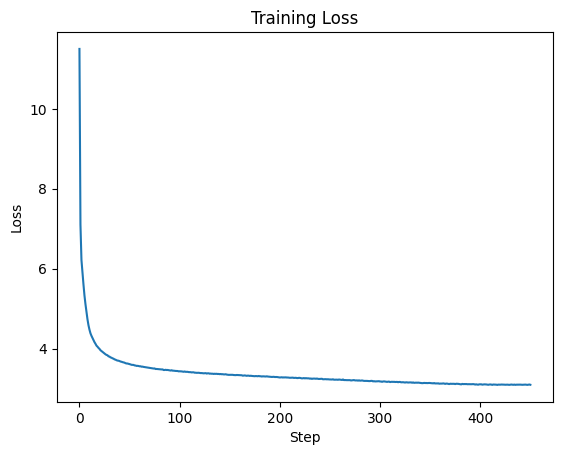

In [ ]:
import matplotlib.pyplot as plt
plt.plot(metrics_history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

As you can see, the model goes from generating completely random words at the beginning to generating sensible sentences at the end of the training.



Here are some training results on Kaggle TPU:

| model | params | train loss | val loss | training time (TPU v3)
| ------| ------ | ---------- | -------- | -----------------------
| gpt2 | 124M         | 3.05  | 3.09     | 6.5 hr
| gpt2-medium | 354M  | 2.83  | 2.86     | 22.5 hr

The losses are roughly in line with [nanoGPT's](https://github.com/karpathy/nanoGPT?tab=readme-ov-file#baselines).

# Model saving

In [ ]:
import orbax.checkpoint as orbax
import shutil

if platform == "Colab":
  checkpoint_path = "/content/checkpoints"
elif platform == "Kaggle":
  checkpoint_path = "/kaggle/working/checkpoints"
else:
  from pathlib import Path
  home = Path.home()
  checkpoint_path = os.path.join(str(home), "checkpoints")

# make sure the folder is empty and usable
shutil.rmtree(checkpoint_path, ignore_errors=True)

checkpointer = orbax.PyTreeCheckpointer()
train_state = nnx.to_pure_dict(nnx.state(model))
checkpointer.save(checkpoint_path, train_state)

# Model restoration
Restore the model checkpoint. A pretrained checkpoint is also available [here](https://www.kaggle.com/models/windmaple/gpt2/).

In [ ]:
model = nnx.eval_shape(lambda: create_model(rngs=nnx.Rngs(0)))
state = nnx.to_pure_dict(nnx.state(model))
checkpointer = orbax.PyTreeCheckpointer()
state = checkpointer.restore(checkpoint_path, item=state)
nnx.update(model, state)

generated_text = model.generate_text(
    seqlen//10, start_tokens
)
print(f"Restored model generated text:\n{generated_text}")

/usr/local/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Once upon a time, a person had a sense of the world and of its meaning. It was the same with the people. The people had a sense of the world and of its meaning.

In the same way, the people had a sense of the world and of its meaning.

In the same way, the people had a sense of the world and of its meaning.

In the same way, the people had a sense of the world and of its meaning.

In the same way,Restored model generated text:
Once upon a time, a person had a sense of the world and of its meaning. It was the same with the people. The people had a sense of the world and of its meaning.

In the same way, the people had a sense of the world and of its meaning.

In the same way, the people had a sense of the world and of its meaning.

In the same way, the people had a sense of the world and of its meaning.

In the same way,


# Disconnect the Colab runtime

In [ ]:
if platform == "Colab":
  from google.colab import runtime
  runtime.unassign()